# Assignment 1: Rice Classification



## Import Statements

In [80]:
!pip install numpy pandas opencv-python scikit-learn matplotlib seaborn tqdm

In [21]:
from tqdm import tqdm
import numpy as np
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


## Auxiliary Functions

In [22]:
def generate_heatmap(conf_matrix, class_labels, title):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(title)
    plt.show()

def calculate_and_print_metrics(y_actual, y_predicted):
    accuracy = accuracy_score(y_actual, y_predicted)
    precision = precision_score(y_actual, y_predicted, average='weighted')
    recall = recall_score(y_actual, y_predicted, average='weighted')
    f1 = f1_score(y_actual, y_predicted, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

## PART I: Textual Data Analysis

This part of the project consists of preprocessing rice data, training different models and evaluating their performances over the classification process of rices.

### Data Preprocessing and Visualization

In our dataset, a few numerical columns had missing values. To handle this, we chose mean imputation, meaning we replaced missing values with the column's average.

We went with this method for a few key reasons:

*Keeps Data Consistent: Since most features are numerical, using the mean ensures the overall data distribution remains stable.

*Computationally Efficient: Unlike complex imputation methods like KNN or regression-based filling, mean imputation is fast and works well for large datasets.


In [23]:
file_path = "data/BBM409_S25_PA1_Dataset_v1/part_i.csv"
df = pd.read_csv(file_path)
raw_data = df
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 107 entries, AREA to CLASS
dtypes: float64(95), int64(11), object(1)
memory usage: 61.2+ MB
None
   AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0  7805    437.915    209.8215     48.0221        0.9735   99.6877    0.9775   
1  7503    340.757    138.3361     69.8417        0.8632   97.7400    0.9660   
2  5124    314.617    141.9803     46.5784        0.9447   80.7718    0.9721   
3  7990    437.085    201.4386     51.2245        0.9671  100.8622    0.9659   
4  7433    342.893    140.3350     68.3927        0.8732   97.2830    0.9831   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         7985  0.3547        4.3693  ...   113.9924    65.0610    59.5989   
1         7767  0.6637        1.9807  ...   105.7055    64.3685    62.2084   
2         5271  0.4760        3.0482  ...   109.7155    62.6423    58.7439   
3         8272  0.6274   

In [24]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

skewB         6
kurtosisB     6
skewCb        3
skewCr        2
kurtosisCb    3
kurtosisCr    2
dtype: int64


In [25]:
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)
rd = raw_data.dropna()

In our dataset, we noticed that some features had outliers, which could negatively impact our machine learning models. Instead of removing outliers and losing valuable data, we decided to scale the features using RobustScaler.

We chose RobustScaler for a few key reaons:

*Resistant to Outliers: Unlike standard scaling methods (like MinMaxScaler or StandardScaler), RobustScaler is not affected by extreme values, as it scales using the median and interquartile range (IQR).

*Preserves Data Integrity: Rather than deleting data points, this method ensures that all values remain in the dataset while minimizing the influence of outliers.

*Improves Model Stability: Scaling helps prevent models from being overly influenced by large values, leading to better generalization and balanced learning.

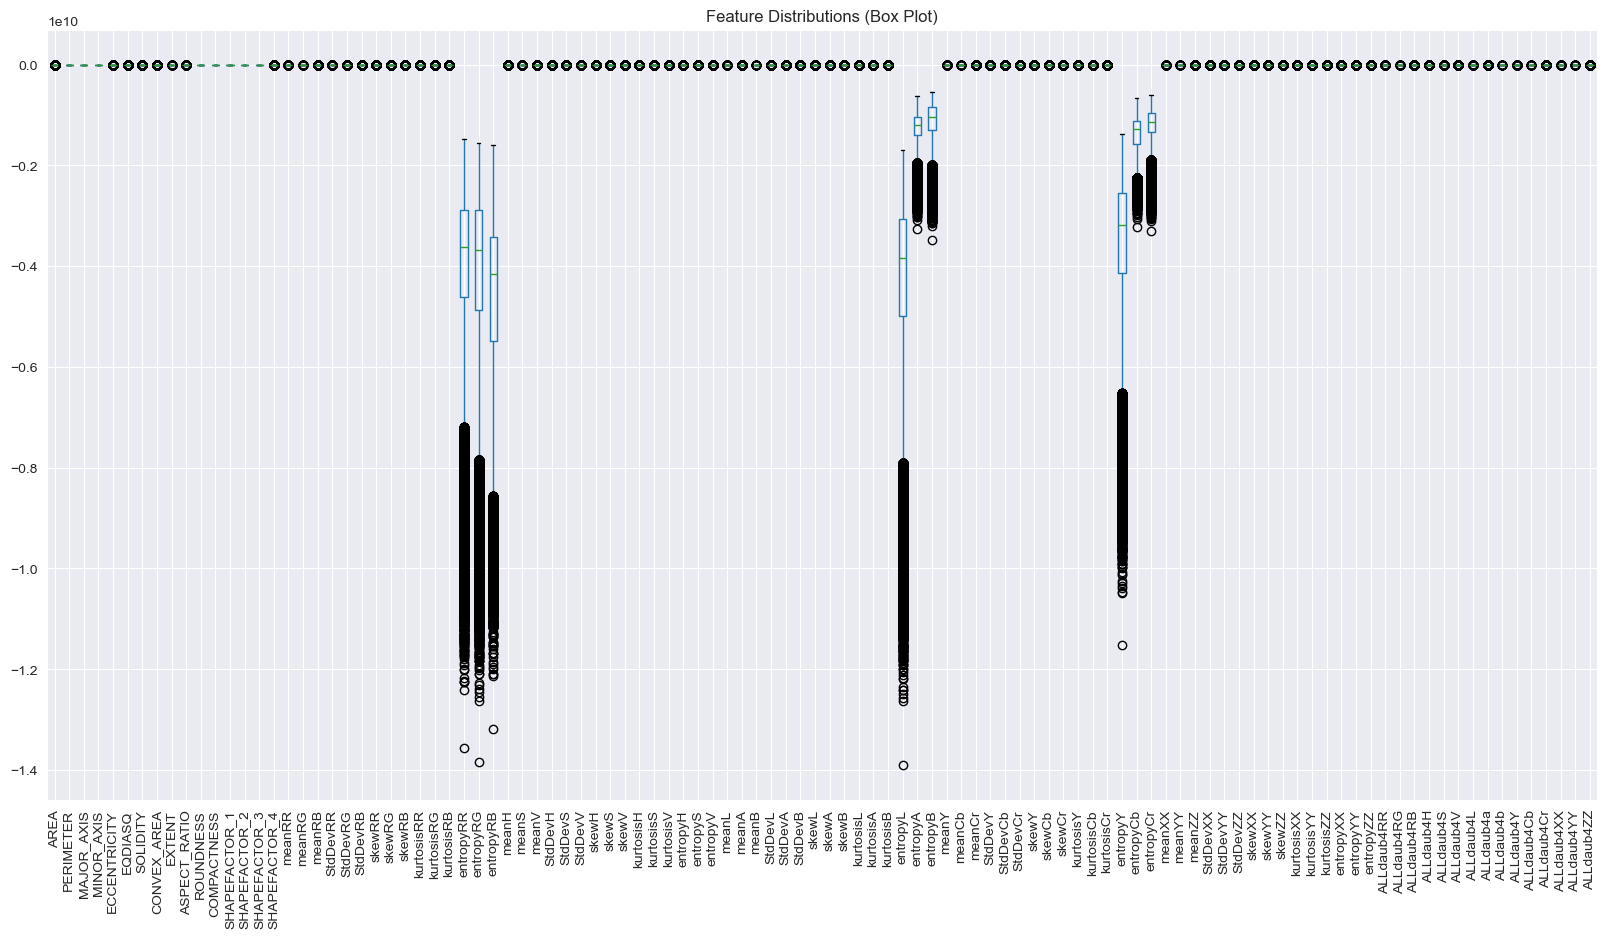

In [26]:
plt.figure(figsize=(20, 10))
df.iloc[:, :-1].boxplot()
plt.xticks(rotation=90)
plt.title("Feature Distributions (Box Plot)")
plt.show()

The correlation map (heatmap) provides a visual representation of how strongly different features are related to each other. In our dataset, many features exhibited high correlation (close to 1.0), meaning they contained almost the same information. Keeping all highly correlated features could lead to redundancy, overfitting, and increased computation time, so we needed to eliminate some of them while preserving the dataset’s predictive power.

*The diagonal line in the heatmap represents a correlation of 1.0, meaning each feature is perfectly correlated with itself (which is expected).

*There are dark red squares, indicating very high correlation (above 0.99) between certain features.

*Blue and light red areas indicate low or moderate correlations, which are usually not problematic.

*Features such as EQDIASQ, CONVEX_AREA, and multiple texture-based features (ALLdaub4XX, ALLdaub4YY, etc.) showed very high correlation with others.

The correlation map showed that many features were highly correlated (>0.99), meaning they contained almost the same information. Keeping them would lead to redundancy, overfitting, and higher computation costs.

To fix this, we removed one feature from each highly correlated pair, keeping the most representative ones. After testing, we confirmed that eliminating these features did not hurt model performance but made the dataset simpler, faster, and more efficient.

In the end, we reduced the feature count from 107 to 65, keeping only the most essential attributes.

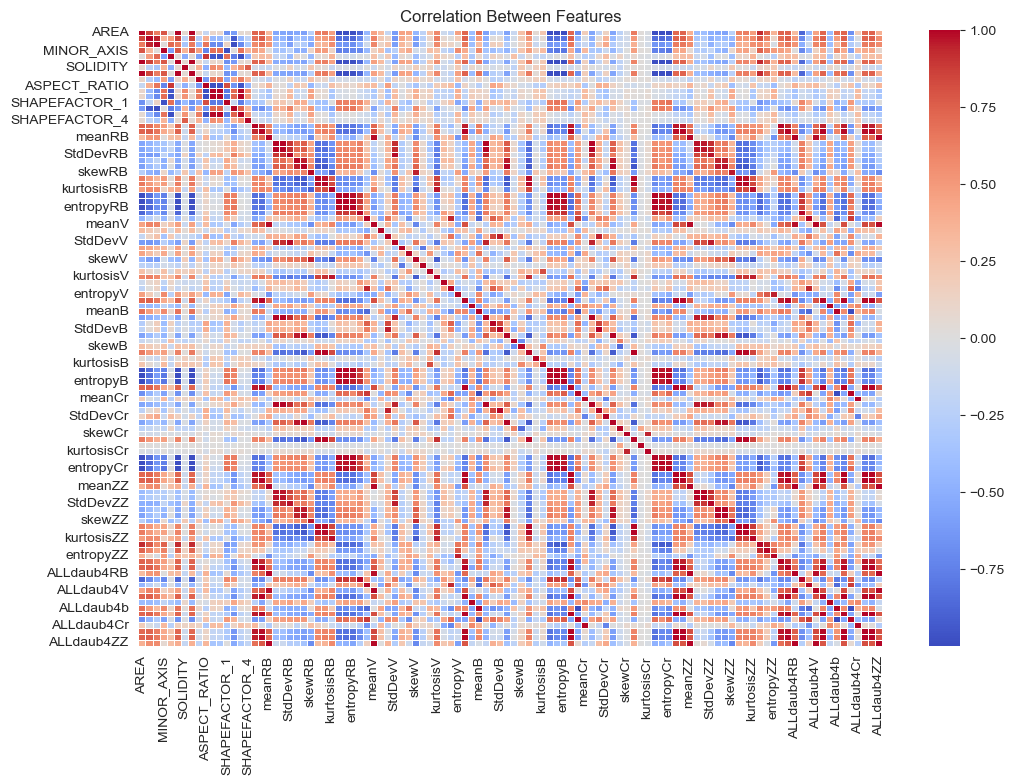

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, :-1].corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Features")
plt.show()

In [28]:
corr_matrix = df.iloc[:, :-1].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
print(f"Features that are eliminated (%99+ correlation): {high_corr_features}")

Features that are eliminated (%99+ correlation): ['EQDIASQ', 'CONVEX_AREA', 'COMPACTNESS', 'SHAPEFACTOR_3', 'StdDevRG', 'entropyRG', 'meanL', 'StdDevL', 'skewL', 'kurtosisL', 'entropyL', 'entropyA', 'entropyB', 'meanY', 'meanCb', 'StdDevY', 'StdDevCb', 'skewY', 'kurtosisY', 'entropyY', 'entropyCr', 'meanXX', 'meanYY', 'meanZZ', 'StdDevYY', 'skewYY', 'kurtosisYY', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB', 'ALLdaub4H', 'ALLdaub4S', 'ALLdaub4V', 'ALLdaub4L', 'ALLdaub4a', 'ALLdaub4b', 'ALLdaub4Y', 'ALLdaub4Cb', 'ALLdaub4Cr', 'ALLdaub4XX', 'ALLdaub4YY', 'ALLdaub4ZZ']


In [29]:
filtered_high_corr_features = [col for col in high_corr_features]
df.drop(columns=filtered_high_corr_features, inplace=True)
print(f"New dataset dimensions: {df.shape}")


New dataset dimensions: (75000, 65)


In [30]:
label_encoder = LabelEncoder()
df["CLASS"] = label_encoder.fit_transform(df["CLASS"])
rd["CLASS"] = label_encoder.fit_transform(rd["CLASS"])
decoded_labels = label_encoder.classes_
print(dict(enumerate(decoded_labels)))


{0: 'Arborio', 1: 'Basmati', 2: 'Ipsala', 3: 'Jasmine', 4: 'Karacadag'}


In [31]:
X = df.drop(columns=["CLASS"])
y = df["CLASS"]
X_raw = rd.drop(columns=["CLASS"])
y_raw = rd["CLASS"]

### Models

Here is the models defined with their hyperparameters. The reason why a robust scaler is used is explained in the "Data Preprocessing and Visualization" section. A K-Fold with 5 splits is defined to ensure the data is split as %80 train and %20 test. K-Fold Cross Validation is used to check the models' performances as it helps to estimate the performances in a more stable way by using all the data as tests and trains at some point.

In [32]:
# Models

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scaler = RobustScaler()

knn = KNeighborsClassifier(n_neighbors=5)
pipeline_knn = make_pipeline(scaler, knn)

weighted_knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
pipeline_weighted_knn = make_pipeline(scaler, weighted_knn)

naive_bayes = GaussianNB()
pipeline_naive_bayes = make_pipeline(scaler, naive_bayes)

random_forest = RandomForestClassifier(n_estimators=100)
pipeline_random_forest = make_pipeline(scaler, random_forest)

svm = SVC(kernel='rbf', C=1.0, gamma=0.1)
pipeline_svm = make_pipeline(scaler, svm)

### Training Models and Evaluations

Scaling the data made a huge difference in the performance of most models. KNN and Weighted KNN saw a significant boost in accuracy, going from around 92.3% to over 99.4%. This makes sense since these models rely heavily on distance calculations, which can be skewed when features have different scales.

Naive Bayes also improved drastically after scaling. Initially, it had the lowest accuracy (70.4%), but after preprocessing, it reached an impressive 99.2%. This suggests that the algorithm struggled with raw feature distributions but worked much better when all features were normalized.

Random Forest, on the other hand, was extremely stable. It performed exceptionally well on both raw and scaled data, maintaining an accuracy of 99.87%. This shows that it’s less sensitive to scaling, likely due to its tree-based nature.

SVM was an interesting case. It wasn’t even feasible to run on the raw data because it took too long to process. However, after scaling, it not only became usable but also reached an accuracy of 99.05%, proving that preprocessing is essential for SVM to work efficiently.

Overall, scaling was a game-changer for distance-based models and Naive Bayes, while Random Forest remained strong regardless of preprocessing.

#### Evaluation Results For Raw Data

For raw data, it is decided to not draw the confusion matrices in order not to reduce the readability of the report.

In [33]:
# KNN

y_knn_pred_raw = cross_val_predict(knn, X_raw, y_raw, cv=kf)
calculate_and_print_metrics(y, y_knn_pred_raw)


Accuracy: 0.9236
Precision: 0.9231
Recall: 0.9236
F1: 0.9231


In [34]:
# Weighted KNN

y_w_knn_pred_raw = cross_val_predict(weighted_knn, X_raw, y_raw, cv=kf)
calculate_and_print_metrics(y, y_w_knn_pred_raw)

Accuracy: 0.9232
Precision: 0.9227
Recall: 0.9232
F1: 0.9227


In [35]:
# Naive Bayes

y_nb_pred_raw = cross_val_predict(naive_bayes, X, y, cv=kf)
calculate_and_print_metrics(y, y_nb_pred_raw)

Accuracy: 0.7122
Precision: 0.7196
Recall: 0.7122
F1: 0.7061


In [36]:
# Random Forest

y_rf_pred_raw = cross_val_predict(random_forest, X, y, cv=kf)
calculate_and_print_metrics(y, y_rf_pred_raw)

Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1: 0.9987


In [ ]:
# SVM

# y_svm_pred_raw = cross_val_predict(svm, X, y, cv=kf)
# calculate_and_print_metrics(y, y_svm_pred_raw)

#### Evaluation Results for Eliminated and Scaled Data

In [37]:
# KNN

y_knn_pred = cross_val_predict(pipeline_knn, X, y, cv=kf)
calculate_and_print_metrics(y, y_knn_pred)

Accuracy: 0.9938
Precision: 0.9938
Recall: 0.9938
F1: 0.9938


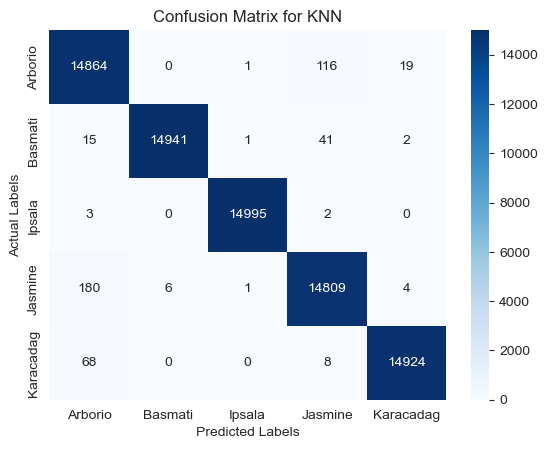

In [38]:
cm_knn = confusion_matrix(y, y_knn_pred, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_knn, decoded_labels, "Confusion Matrix for KNN")

In [39]:
# Weighted KNN

y_w_knn_pred = cross_val_predict(pipeline_weighted_knn, X, y, cv=kf)
calculate_and_print_metrics(y, y_w_knn_pred)

Accuracy: 0.9941
Precision: 0.9941
Recall: 0.9941
F1: 0.9941


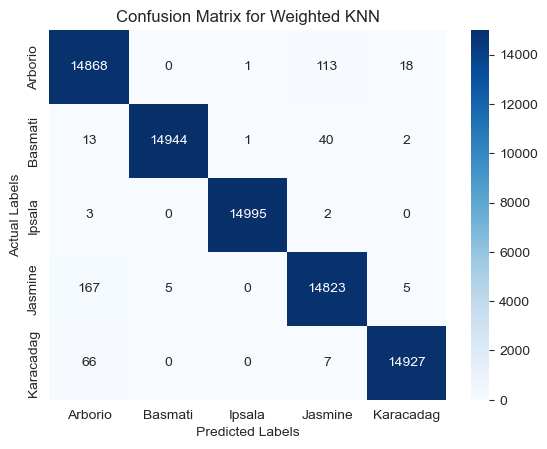

In [40]:
cm_w_knn = confusion_matrix(y, y_w_knn_pred, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_w_knn, decoded_labels, "Confusion Matrix for Weighted KNN")

In [41]:
# Naive Bayes

y_nb_pred = cross_val_predict(pipeline_naive_bayes, X, y, cv=kf)
calculate_and_print_metrics(y, y_nb_pred)

Accuracy: 0.9924
Precision: 0.9925
Recall: 0.9924
F1: 0.9924


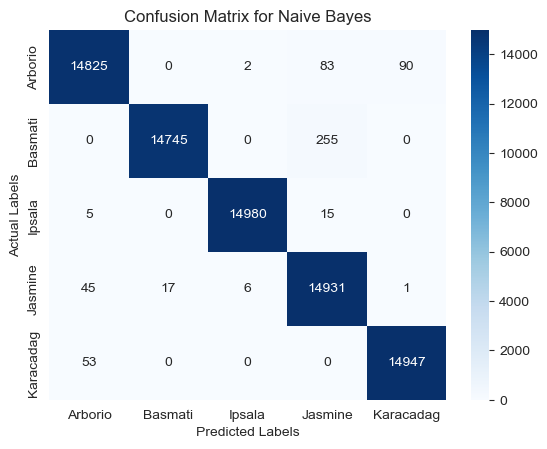

In [42]:
cm_nb = confusion_matrix(y, y_nb_pred, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_nb, decoded_labels, "Confusion Matrix for Naive Bayes")

In [43]:
# Random Forest

y_rf_pred = cross_val_predict(pipeline_random_forest, X, y, cv=kf)
calculate_and_print_metrics(y, y_rf_pred)

Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F1: 0.9986


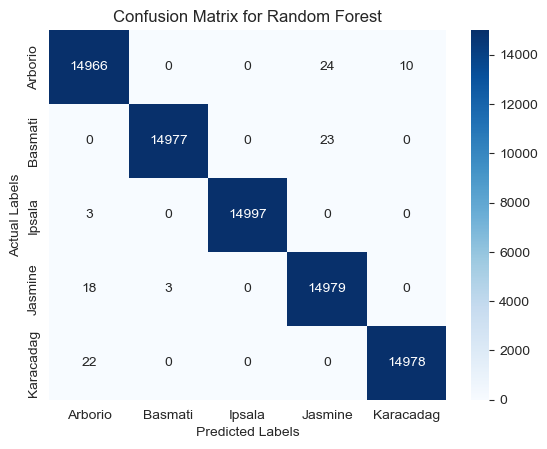

In [44]:
cm_rf = confusion_matrix(y, y_rf_pred, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rf, decoded_labels, "Confusion Matrix for Random Forest")

In [45]:
# SVM

y_svm_pred = cross_val_predict(pipeline_svm, X, y, cv=kf)
calculate_and_print_metrics(y, y_svm_pred)

Accuracy: 0.9906
Precision: 0.9909
Recall: 0.9906
F1: 0.9906


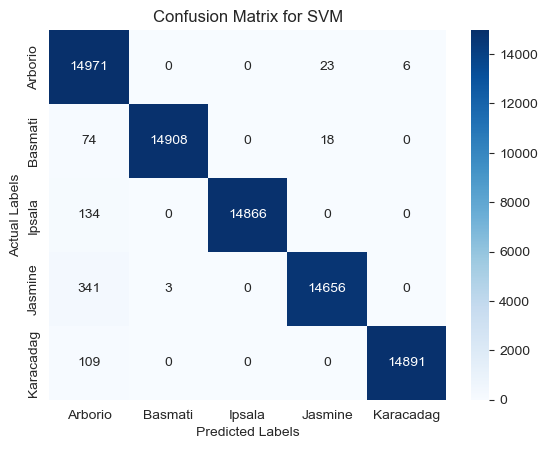

In [47]:
cm_svm = confusion_matrix(y, y_svm_pred, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_svm, decoded_labels, "Confusion Matrix for SVM")

## PART II: Image Data Analysis

This part of the project consists of extracting features from rice images, training different models and evaluating their performances over the classification process of rices.

### Data Processing and Feature Extraction

In this code cell, image files are read with their labels. Since the image files are too large (250x250), they needed resizing. Pixel values are intended to be used as features, that's why a reasonable size is tried to be chosen as choosing the size too large would make the feature space larger meaning higher computational cost. At the same time, making the images too small would mean that they could lose their characteristics. As a medium between these two, a size of 16x16 chosen.

In [48]:
# Read and resize the images with labels
images = []
labels = []

dataset_path = "data/BBM409_S25_PA1_Dataset_v1/part_ii"
for folder_name in tqdm(os.listdir(dataset_path), desc="Rice Folder Loops"):
    folder_path = os.path.join(dataset_path, folder_name)
    for img_name in tqdm(os.listdir(folder_path), desc="Image Loops"):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        # Resize to reduce the feature size
        img = cv2.resize(img, (16, 16))
        images.append(img)
        labels.append(folder_name)


Rice Folder Loops: 100%|██████████| 5/5 [03:38<00:00, 43.63s/it]


Here, labels are encoded as numerical values.

In [49]:
# Encode labels
label_encoder = LabelEncoder()
Y_RGB = label_encoder.fit_transform(labels)
Y_BINARY = label_encoder.fit_transform(labels)
decoded_labels = label_encoder.inverse_transform([0, 1, 2, 3, 4])

In this code cell, two different feature sets are extracted from the images. The main idea is to use the rgb values as features in one set and the binary values in the other set. In the rgb based features, the images are resized to be 8x8 to keep the feature size around ~200. Gaussian Blur is used to blend the sharpness that happened due to the resizing process. In the binary based features, since there are one value per pixel, further resizing is not needed because feature space would be around ~200 (256 to be exact) and the size is kept 16x16. A basic thresholding operation is applied to get the binary values.

In [50]:
# Extract features
def extract_rgb_features(image):
    image = cv2.resize(image, (8, 8))
    image = cv2.GaussianBlur(image, (3, 3), 0)
    return image

def extract_binary_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1]
    return image

rgb_images = [extract_rgb_features(img) for img in images]
binary_images = [extract_binary_features(img) for img in images]

X_RGB = np.array([img.flatten() for img in rgb_images])
X_BINARY = np.array([img.flatten() for img in binary_images])

The data is shuffled with a fixed state.

In [51]:
# Shuffle the data
X_RGB, Y_RGB = shuffle(X_RGB, Y_RGB, random_state=42)
X_BINARY, Y_BINARY = shuffle(X_BINARY, Y_BINARY, random_state=42)

### Data Visualization

Since the pixel values are used as features and they are valued between 0 and 255, there are no outliers in the features. That's why visualizing the data and the properties of it does not mean much. Instead a reference picture of how the images look after the processing is done is shown.

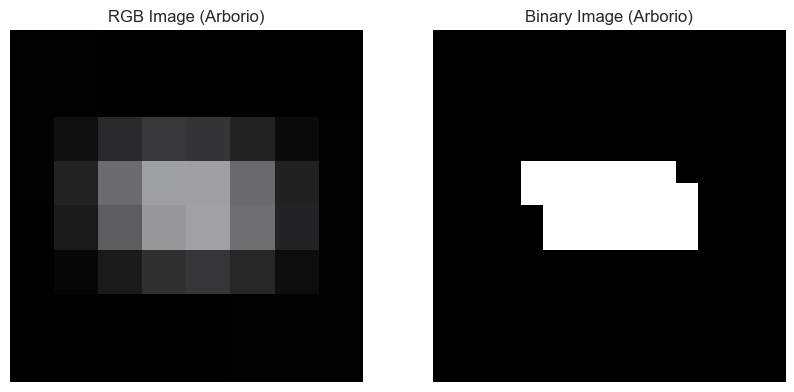

In [52]:
# Example sized down images for a Arborio rice

example_rgb = cv2.cvtColor(rgb_images[0], cv2.COLOR_BGR2RGB)
example_binary = binary_images[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(example_rgb)
axes[0].axis('off')
axes[0].set_title('RGB Image (Arborio)')

axes[1].imshow(example_binary, cmap='gray')  # Use grayscale for binary images
axes[1].axis('off')
axes[1].set_title('Binary Image (Arborio)')

plt.show()


These are the feature correlation heatmaps of the two feature set. Since they are images of objects, its natural that there are correlations between the features hence the pixels. In the rgb one, it can be seen that for each pixel's rgb values are correlated with each other. This means that, for reducing the feature size, from each pixel one of the rgb values can be chosen if needed.

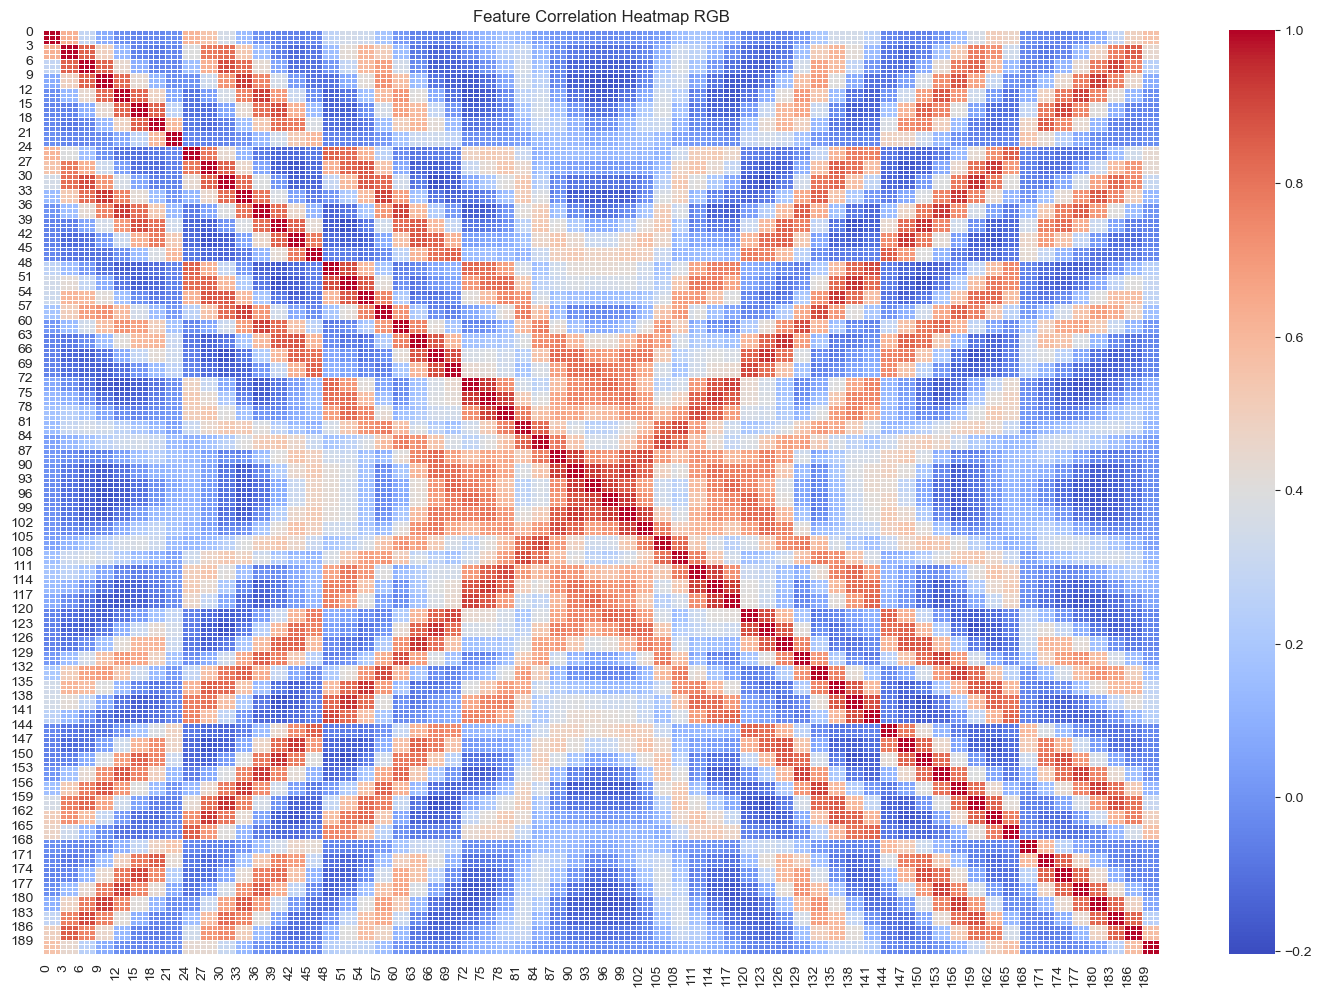

In [53]:
X_RGB_df = pd.DataFrame(X_RGB)
corr_matrix_rgb = X_RGB_df.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix_rgb, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap RGB")
plt.show()


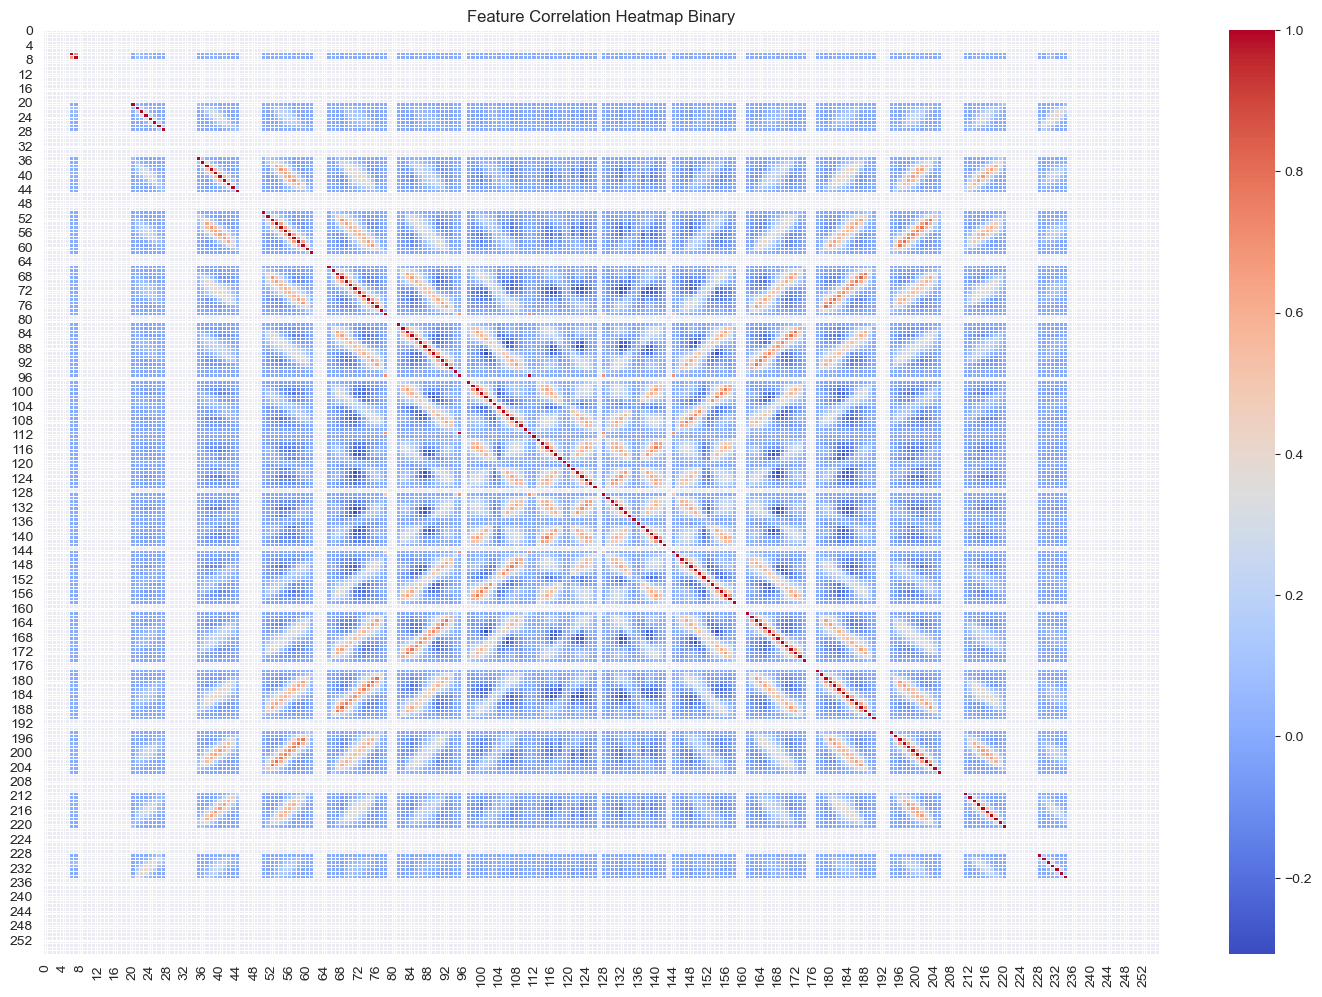

In [54]:
X_BINARY_df = pd.DataFrame(X_BINARY)
corr_matrix_binary = X_BINARY_df.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix_binary, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap Binary")
plt.show()

### Models

Here is the models defined with their hyperparameters. A min max scaler is decided to be used as the pixel values are between known boundaries, so there are no outliers possible. A K-Fold with 5 splits is defined to ensure the data is split as %80 train and %20 test. K-Fold Cross Validation is used to check the models' performances as it helps to estimate the performances in a more stable way by using all the data as tests and trains at some point.

In [55]:
# Models

kf = KFold(n_splits=5, shuffle=True, random_state=42)

min_max_scaler = MinMaxScaler()

knn = KNeighborsClassifier(n_neighbors=5)
pipeline_knn = make_pipeline(min_max_scaler, knn)

weighted_knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
pipeline_weighted_knn = make_pipeline(min_max_scaler, weighted_knn)

naive_bayes = GaussianNB()
pipeline_naive_bayes = make_pipeline(min_max_scaler, naive_bayes)

random_forest = RandomForestClassifier(n_estimators=100)
pipeline_random_forest = make_pipeline(min_max_scaler, random_forest)

svm = SVC(kernel='rbf', C=1.0, gamma=0.1)
pipeline_svm = make_pipeline(min_max_scaler, svm)



### Training Models and Evaluations


#### RGB Feature Set

Some observations can be made by looking at the evaluation metric results and confusion matrices.

All the models except the Naive Bayes gave pretty good scores in all metrics. Naive Bayes' poor performance might be due to how the model assumes all features are conditionally independent. In an image, the features are often correlated. Since the features are the pixels, spatial relationships between the pixels plays a crucial role in identifying the class of the rice. Naive Bayes treats every pixel independently, failing to capture the relationships between the pixels, resulting in a poor performance.

By looking at the confusion matrices of the all the models except Naive Bayes, it can be seen that the small errors are due to the misclassification between the classes Arborio-Karacadag and Basmati-Jasmine. By looking at the images of these rice types, it can be seen that they are looking structurally same with each other, Arborio-Karacadag looks more compact and round, Basmati-Jasmine are longer and thinner. To correctly classify them further, extracting more features possibly related to edge and corner values might be needed.

In [56]:
# KNN Evaluation For RGB features

Y_RGB_KNN_PRED = cross_val_predict(pipeline_knn, X_RGB, Y_RGB, cv=kf)
calculate_and_print_metrics(Y_RGB, Y_RGB_KNN_PRED)


Accuracy: 0.9681
Precision: 0.9682
Recall: 0.9681
F1: 0.9681


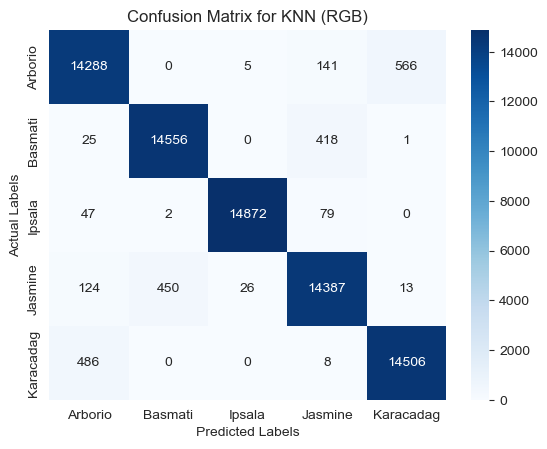

In [57]:
cm_rgb_knn = confusion_matrix(Y_RGB, Y_RGB_KNN_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rgb_knn, decoded_labels, "Confusion Matrix for KNN (RGB)")

In [58]:
# Weighted KNN Evaluation for RGB features

Y_RGB_W_KNN_PRED = cross_val_predict(pipeline_weighted_knn, X_RGB, Y_RGB, cv=kf)
calculate_and_print_metrics(Y_RGB, Y_RGB_W_KNN_PRED)


Accuracy: 0.9688
Precision: 0.9688
Recall: 0.9688
F1: 0.9688


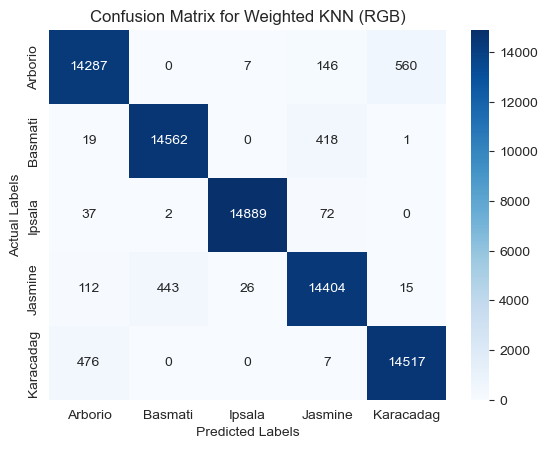

In [59]:
cm_rgb_w_knn = confusion_matrix(Y_RGB, Y_RGB_W_KNN_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rgb_w_knn, decoded_labels, "Confusion Matrix for Weighted KNN (RGB)")

In [60]:
# Naive Bayes Evaluation for RGB features

Y_RGB_NB_PRED = cross_val_predict(pipeline_naive_bayes, X_RGB, Y_RGB, cv=kf)
calculate_and_print_metrics(Y_RGB, Y_RGB_NB_PRED)

Accuracy: 0.6068
Precision: 0.6007
Recall: 0.6068
F1: 0.5729


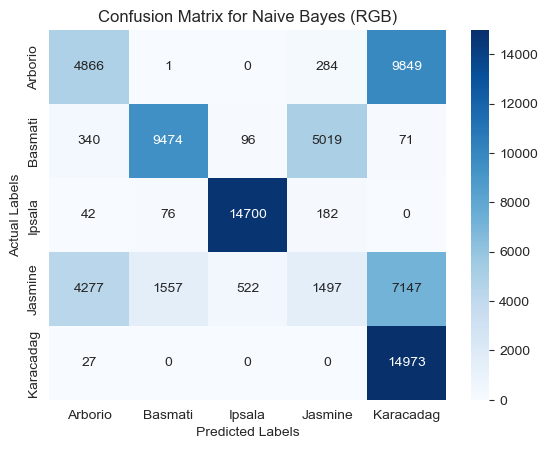

In [61]:
cm_rgb_nb = confusion_matrix(Y_RGB, Y_RGB_NB_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rgb_nb, decoded_labels, "Confusion Matrix for Naive Bayes (RGB)")

In [62]:
# Random Forest Evaluation for RGB features

Y_RGB_RF_PRED = cross_val_predict(pipeline_random_forest, X_RGB, Y_RGB, cv=kf)
calculate_and_print_metrics(Y_RGB, Y_RGB_RF_PRED)

Accuracy: 0.9776
Precision: 0.9776
Recall: 0.9776
F1: 0.9776


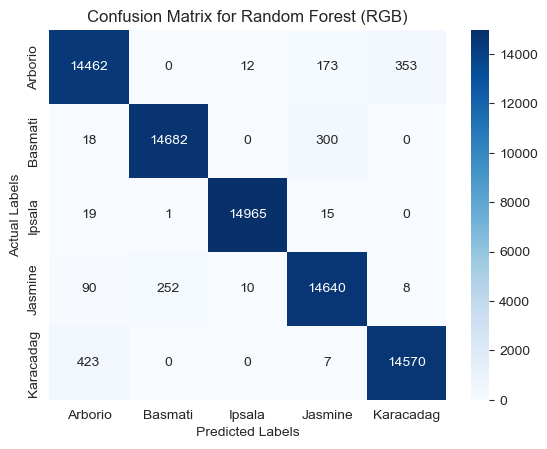

In [63]:
cm_rgb_rf = confusion_matrix(Y_RGB, Y_RGB_RF_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rgb_rf, decoded_labels, "Confusion Matrix for Random Forest (RGB)")

In [64]:
# SVM Evaluation for RGB features

Y_RGB_SVM_PRED = cross_val_predict(pipeline_svm, X_RGB, Y_RGB, cv=kf)
calculate_and_print_metrics(Y_RGB, Y_RGB_SVM_PRED)


Accuracy: 0.9782
Precision: 0.9784
Recall: 0.9782
F1: 0.9783


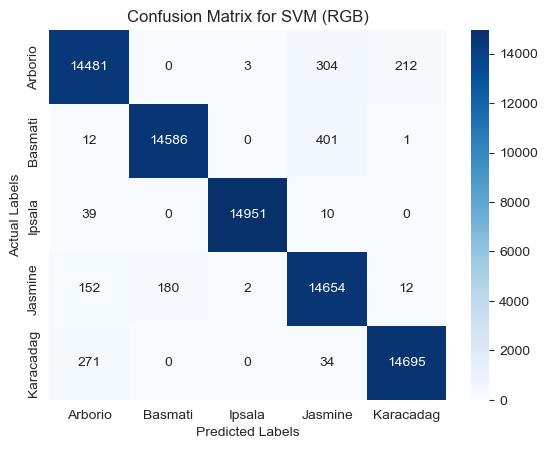

In [65]:
cm_rgb_svm = confusion_matrix(Y_RGB, Y_RGB_SVM_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_rgb_svm, decoded_labels, "Confusion Matrix for SVM (RGB)")

#### Binary Feature Set

The observations that are done in the RGB Feature Set part can be made in this feature set as well.

The main difference between this feature set and the rgb one is that the features are extracted from bigger pictures (16x16 instead of 8x8) and pixel values in each location is represented by binary values instead of three rgb values. The observed scores show us that while them still having pretty good results except Naive Bayes model, they are slightly lower in comparison to RGB feature set scores.

Even though the features are extracted from bigger images, the color information is lost. Since in both of these feature sets only pixel values are relied on, color information plays a role that can alter the classification processes. If there would be more features regarding the spacial and structural properties for the rices, such as edge and corner information, roundness, width/height ratio, the loss of the color information might've altered the process less.

It can be observed from the confusion matrices the little drop in the scores are mostly due to the increase of the misclassifications between Arborio-Karacadag and Basmati-Jasmine. Since they are structurally similar, loss of color information raised the number of cases that are misclassified.

In the case of Naive Bayes model scores, it can be seen that there is a slight improvement. This is mostly due to the fact that by reducing feature by per pixel from three (rgb) to one (binary), the correlation between the features are less dependent. Since Naive Bayes assumes feature independence, this approach might've lead to slightly better results.


In [66]:
# KNN Evaluation For Binary Features

Y_BINARY_KNN_PRED = cross_val_predict(pipeline_knn, X_BINARY, Y_BINARY, cv=kf)
calculate_and_print_metrics(Y_BINARY, Y_BINARY_KNN_PRED)

Accuracy: 0.9438
Precision: 0.9440
Recall: 0.9438
F1: 0.9439


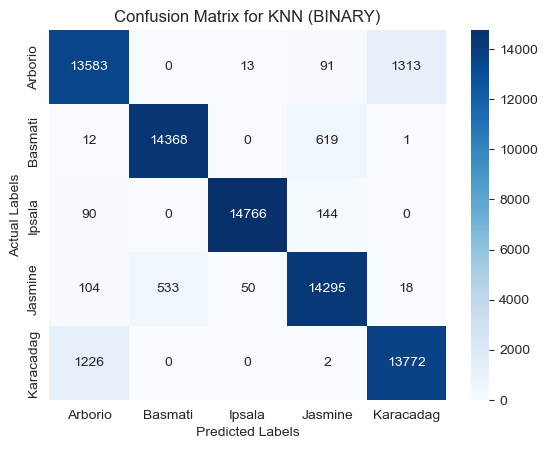

In [67]:
cm_binary_knn = confusion_matrix(Y_BINARY, Y_BINARY_KNN_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_binary_knn, decoded_labels, "Confusion Matrix for KNN (BINARY)")

In [68]:
# Weighted KNN Evaluation for Binary features

Y_BINARY_W_KNN_PRED = cross_val_predict(pipeline_weighted_knn, X_BINARY, Y_BINARY, cv=kf)
calculate_and_print_metrics(Y_BINARY, Y_BINARY_W_KNN_PRED)


Accuracy: 0.9417
Precision: 0.9418
Recall: 0.9417
F1: 0.9417


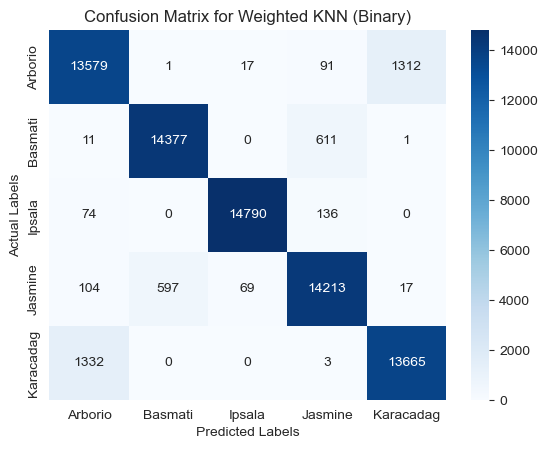

In [69]:
cm_binary_w_knn = confusion_matrix(Y_BINARY, Y_BINARY_W_KNN_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_binary_w_knn, decoded_labels, "Confusion Matrix for Weighted KNN (Binary)")

In [70]:
# Naive Bayes Evaluation for Binary features

Y_BINARY_NB_PRED = cross_val_predict(pipeline_naive_bayes, X_BINARY, Y_BINARY, cv=kf)
calculate_and_print_metrics(Y_BINARY, Y_BINARY_NB_PRED)

Accuracy: 0.6386
Precision: 0.6873
Recall: 0.6386
F1: 0.6323


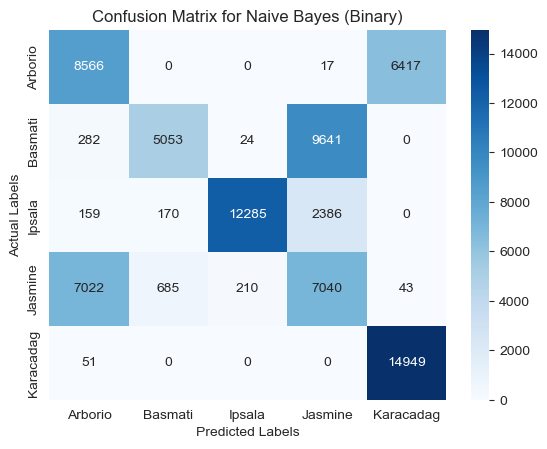

In [71]:
cm_binary_nb = confusion_matrix(Y_BINARY, Y_BINARY_NB_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_binary_nb, decoded_labels, "Confusion Matrix for Naive Bayes (Binary)")

In [72]:
# Random Forest Evaluation for Binary features

Y_BINARY_RF_PRED = cross_val_predict(pipeline_random_forest, X_BINARY, Y_BINARY, cv=kf)
calculate_and_print_metrics(Y_BINARY, Y_BINARY_RF_PRED)

Accuracy: 0.9487
Precision: 0.9488
Recall: 0.9487
F1: 0.9487


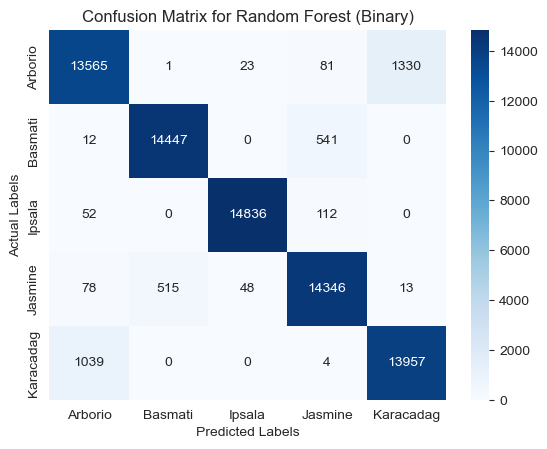

In [73]:
cm_binary_rf = confusion_matrix(Y_BINARY, Y_BINARY_RF_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_binary_rf, decoded_labels, "Confusion Matrix for Random Forest (Binary)")

In [74]:
# SVM Evaluation for Binary Features

Y_BINARY_SVM_PRED = cross_val_predict(pipeline_svm, X_BINARY, Y_BINARY, cv=kf)
calculate_and_print_metrics(Y_BINARY, Y_BINARY_SVM_PRED)


Accuracy: 0.9504
Precision: 0.9506
Recall: 0.9504
F1: 0.9505


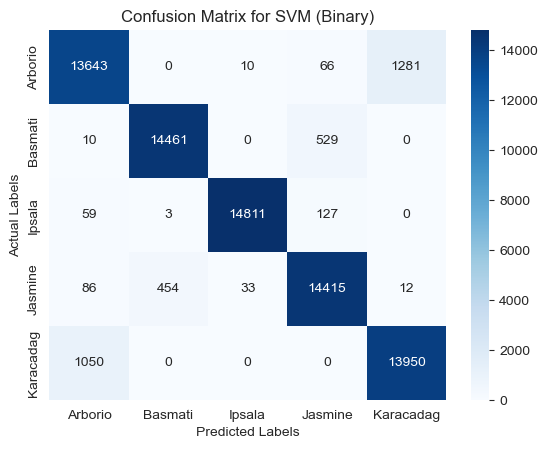

In [75]:
cm_binary_svm = confusion_matrix(Y_BINARY, Y_BINARY_SVM_PRED, labels=[0, 1, 2, 3, 4])
generate_heatmap(cm_binary_svm, decoded_labels, "Confusion Matrix for SVM (Binary)")

### Hyperparameter Optimization for KNN using RGB Features


In this part of the project, a hyperparameter optimization for the k neighbor value for knn model is conducted. For choosing the best k, the rgb feature set is tried with values 1 from 10 with 5-fold cross validation. Then accuracy scores are kept, and the highest is chosen to be the optimal value (k=3 in this case).

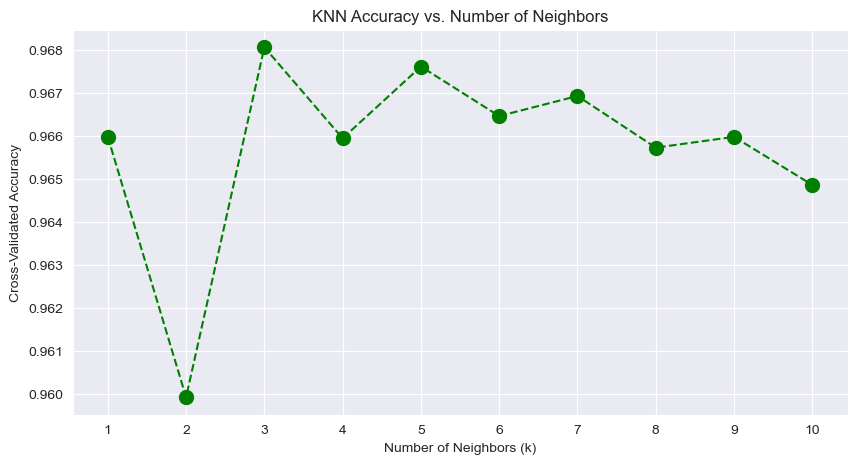

In [79]:
x_train_rgb, x_test_rgb, y_train_rgb, y_test_rgb = train_test_split(X_RGB, Y_RGB, test_size=0.2, random_state=42)

k_values = range(1, 11)
knn_accuracies = []

for k in k_values:
    knn_opt = KNeighborsClassifier(n_neighbors=k)
    pipeline_knn_opt = make_pipeline(min_max_scaler, knn_opt)
    scores = cross_val_score(pipeline_knn_opt, x_train_rgb, y_train_rgb, cv=kf)
    knn_accuracies.append(scores.mean())

plt.figure(figsize=(10, 5))
plt.plot(k_values, knn_accuracies, marker='o', linestyle='dashed', markersize=10, color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xticks(k_values)
plt.grid(True)
plt.show()
